In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
# import keras_tuner
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from tensorflow.keras.applications.resnet50 import ResNet50


#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2024-04-13 14:11:47.825014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 14:11:48.714390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


In [2]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 32
seeds = 41
im_shape = (250,250)

In [4]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


## ResNet50

In [5]:
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(250,250,3))

for layer in resnet50.layers:
    layer.trainable=False

resnet_model = Sequential()
resnet_model.add(resnet50)
resnet_model.add(BatchNormalization())
resnet_model.add(GlobalAveragePooling2D())
# resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(2048, activation='relu'))
# resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(6, activation='softmax'))
resnet_model.summary()

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-04-13 14:11:56.693194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 14:11:56.702085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 14:11:56.702364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization (Batch  (None, 8, 8, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 27804550 (106.07 MB)
Trainable params: 421

In [6]:
from tensorflow.keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
import time
# Record the start time of training
start_time = time.time()

In [8]:
# Train the model
epochs = 10

#Training
resnet_history = resnet_model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/10


2024-04-13 14:12:14.662468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-13 14:12:15.912426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-13 14:12:16.908121: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1e0c5080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 14:12:16.908199: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-13 14:12:16.919670: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 14:12:17.120500: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

53/53 [==============================] - 59s 965ms/step - loss: 1.6329 - accuracy: 0.3470 - val_loss: 1.8062 - val_accuracy: 0.2262
Epoch 2/10
53/53 [==============================] - 51s 956ms/step - loss: 1.4719 - accuracy: 0.4381 - val_loss: 1.7791 - val_accuracy: 0.1833
Epoch 3/10
53/53 [==============================] - 50s 950ms/step - loss: 1.3855 - accuracy: 0.4750 - val_loss: 1.6668 - val_accuracy: 0.2929
Epoch 4/10
53/53 [==============================] - 49s 933ms/step - loss: 1.3335 - accuracy: 0.4690 - val_loss: 1.5498 - val_accuracy: 0.3595
Epoch 5/10
53/53 [==============================] - 49s 919ms/step - loss: 1.2883 - accuracy: 0.5030 - val_loss: 1.4722 - val_accuracy: 0.4286
Epoch 6/10
53/53 [==============================] - 51s 969ms/step - loss: 1.2303 - accuracy: 0.5304 - val_loss: 1.4095 - val_accuracy: 0.4833
Epoch 7/10
53/53 [==============================] - 49s 929ms/step - loss: 1.1938 - accuracy: 0.5458 - val_loss: 1.3513 - val_accuracy: 0.4810
Epoch 8/10

In [9]:
# Record the training end time
end_time = time.time()

In [10]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 713.618005990982 seconds


In [11]:
pd.DataFrame(resnet_history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.632860,0.347024,1.806158,0.226190
1,1.471932,0.438095,1.779083,0.183333
2,1.385487,0.475000,1.666810,0.292857
3,1.333451,0.469048,1.549798,0.359524
4,1.288283,0.502976,1.472189,0.428571
5,1.230349,0.530357,1.409521,0.483333
6,1.193830,0.545833,1.351286,0.480952
7,1.151291,0.583929,1.289113,0.519048
8,1.109346,0.589881,1.244471,0.566667
9,1.083064,0.605952,1.235253,0.552381


In [12]:
import joblib

joblib.dump(resnet_history.history,'history_ResNet50_0.0001lr.pkl')
resnet_history = joblib.load('history_ResNet50_0.0001lr.pkl')

In [13]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

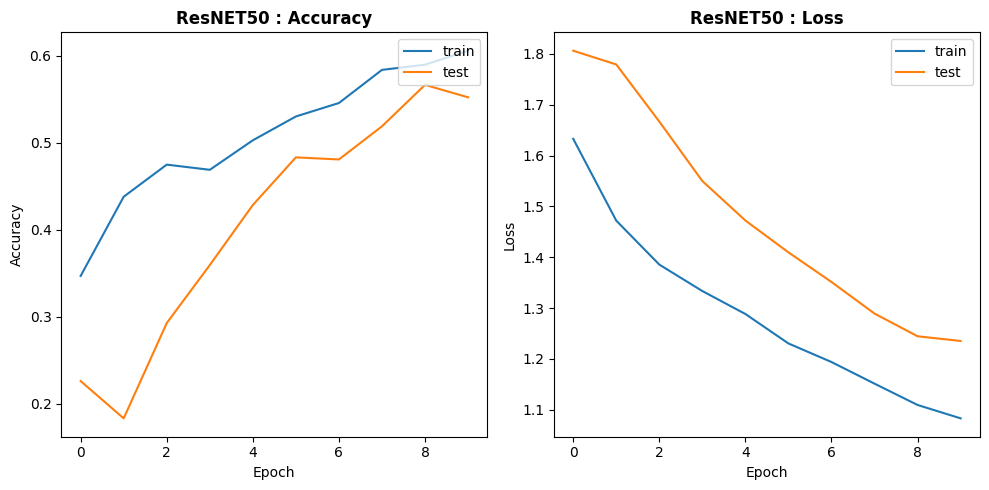

In [14]:
plot_performance(model_name='ResNET50',
                acc=resnet_history['accuracy'], 
                 val_acc=resnet_history['val_accuracy'],
                 loss=resnet_history['loss'], 
                 val_loss=resnet_history['val_loss'])

In [15]:
resnet_model.save('resnet_model_0.0001lr.h5')

In [16]:
# Load the best saved model
from keras.models import load_model

model_1 = load_model('resnet_model_0.0001lr.h5')
score = model_1.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model_1.evaluate(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

14/14 [==============================] - 11s 709ms/step - loss: 1.2523 - accuracy: 0.5619

Val loss: 1.2522870302200317
Val accuracy: 0.561904788017273
17/17 [==============================] - 14s 835ms/step - loss: 1.1703 - accuracy: 0.5568

Test loss: 1.1703068017959595
Test accuracy: 0.5568181872367859


In [17]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

17/17 [==============================] - 13s 704ms/step
Classification Report
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.48      0.83      0.61        88
           brown_spot       0.47      0.23      0.31        88
              healthy       0.60      0.55      0.57        88
           leaf_blast       0.41      0.38      0.39        88
           leaf_scald       0.67      0.70      0.69        88
    narrow_brown_spot       0.66      0.60      0.63        88

             accuracy                           0.55       528
            macro avg       0.55      0.55      0.53       528
         weighted avg       0.55      0.55      0.53       528



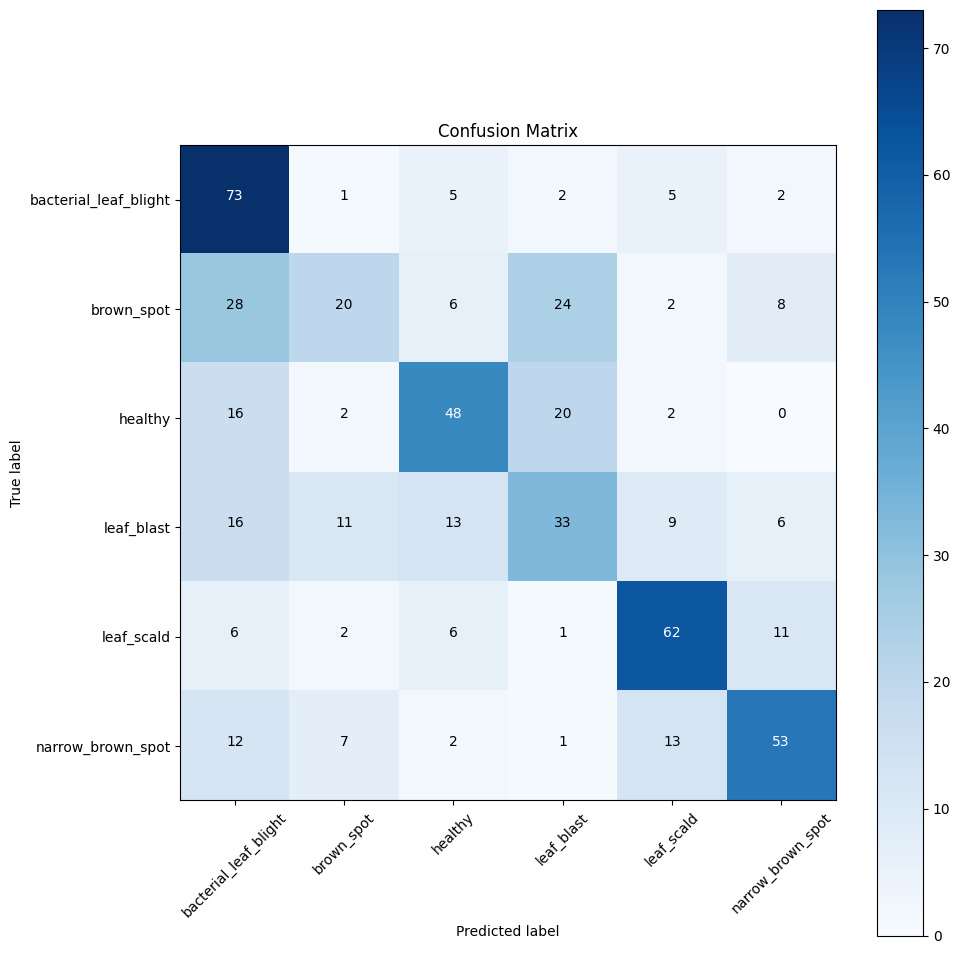

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model_1.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))